In [1]:
# import libraries
import sqlite3
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower, tt_ind_solve_power
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [46]:
def bootstrap(arr):
    return np.random.choice(arr, size=arr.shape, replace=True)


def generate_sample_mus(arr, num_samples=30):
    sample_mus = [] 
    for i in range(num_samples):
        sample = bootstrap(arr)
        mu = np.mean(sample)
        sample_mus.append(mu)
    return sample_mus


def test_for_normality(arr, confidence=0.95):
    t, p = scs.shapiro(arr)
    if p <= 1 - confidence:
        print("reject the null")
        return False
    print("fail to reject the null")
    return True


def cohens_d(arr1, arr2):
    narr1 = len(arr1)
    narr2 = len(arr2)
    dof = narr1 + narr2 - 2
    return (np.mean(arr1) - np.mean(arr2)) / np.sqrt(((narr1-1)*np.std(arr1, ddof=1) ** 2 + (narr2-1)*np.std(arr2, ddof=1) ** 2) / dof)

In [2]:
# investigate data
conn = sqlite3.connect('../data/northWind.sqlite')
cur = conn.cursor()

In [3]:
cur.execute("""SELECT * FROM Product p join orderdetail od on p.id = od.productid;
          """)
products_df = pd.DataFrame(cur.fetchall())
products_df.columns = [x[0] for x in cur.description]

# Question 1: Is there a difference in quantity of products sold by discount rate? 

Paired T-Test

H0: There is no difference in the quantity of products sold based on how much they are discounted

HA: More products are sold when they are discounted versus when they are full price

In [4]:
products_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0,10248/11,10248,11,14.0,12,0.0
1,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1,10248/42,10248,42,9.8,10,0.0
2,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0,10248/72,10248,72,34.8,5,0.0
3,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0,10249/14,10249,14,18.6,9,0.0
4,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0,10249/51,10249,51,42.4,40,0.0


In [5]:
products_df.isna().sum()

Id                 0
ProductName        0
SupplierId         0
CategoryId         0
QuantityPerUnit    0
UnitPrice          0
UnitsInStock       0
UnitsOnOrder       0
ReorderLevel       0
Discontinued       0
Id                 0
OrderId            0
ProductId          0
UnitPrice          0
Quantity           0
Discount           0
dtype: int64

In [33]:
discounts = products_df.Discount.value_counts().sort_index()
discounts

0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Discount, dtype: int64

In [52]:
zero_df = products_df.loc[products_df['Discount']==0.00, 'Quantity']
dis_df = products_df.loc[products_df['Discount']!=0.00, 'Quantity']

In [55]:
print(zero_df.sum(),dis_df.sum())

28599 22718


In [57]:
dis_df

6       35
7       15
8        6
9       15
11      40
        ..
2144     2
2146     3
2149     2
2150     2
2152     2
Name: Quantity, Length: 838, dtype: int64

In [39]:
# zero_dis = products_df.loc[products_df['Discount']==0.00, 'Quantity']
# one_dis = products_df.loc[products_df['Discount']==0.01, 'Quantity']
# two_dis = products_df.loc[products_df['Discount']==0.02, 'Quantity']
# three_dis = products_df.loc[products_df['Discount']==0.03, 'Quantity']
# four_dis = products_df.loc[products_df['Discount']==0.04, 'Quantity']
# five_dis = products_df.loc[products_df['Discount']==0.05, 'Quantity']
# six_dis = products_df.loc[products_df['Discount']==0.06, 'Quantity']
# ten_dis = products_df.loc[products_df['Discount']==0.10, 'Quantity']
# fifteen_dis = products_df.loc[products_df['Discount']==0.15, 'Quantity']
# twenty_dis = products_df.loc[products_df['Discount']==0.20, 'Quantity']
# twentyfive_dis = products_df.loc[products_df['Discount']==0.25, 'Quantity']

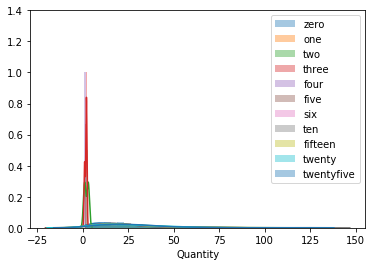

In [47]:
# sns.distplot(zero_dis, label="zero")
# sns.distplot(one_dis, label="one")
# sns.distplot(two_dis, label="two")
# sns.distplot(three_dis, label="three")
# sns.distplot(four_dis, label="four")
# sns.distplot(five_dis, label="five")
# sns.distplot(six_dis, label="six")
# sns.distplot(ten_dis, label="ten")
# sns.distplot(fifteen_dis, label="fifteen")
# sns.distplot(twenty_dis, label="twenty")
# sns.distplot(twentyfive_dis, label="twentyfive")
# plt.legend()

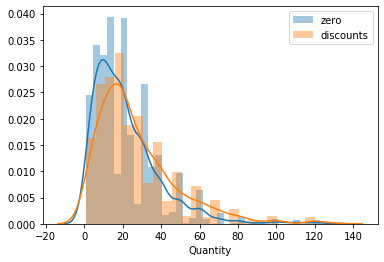

In [60]:
sns.distplot(zero_df, label="zero")
sns.distplot(dis_df, label="discounts")
plt.legend();

### Can use below if we want to separate out individual products and their discount rates - otherwise we're grouping all discount rates and the quantities sold of each

In [10]:
# grouped_prod_disc = products_df.groupby(by=['Discount', 'ProductId']).sum()


In [61]:
print(test_for_normality(zero_df), test_for_normality(dis_df))

reject the null
reject the null
False False


In [62]:
sample_quant_zero = generate_sample_mus(zero_df)
sample_quant_dis = generate_sample_mus(dis_df)


In [70]:
print(test_for_normality(sample_quant_zero), test_for_normality(sample_quant_dis))

fail to reject the null
fail to reject the null
True True


(<matplotlib.axes._subplots.AxesSubplot at 0x207631d0548>,
 <matplotlib.axes._subplots.AxesSubplot at 0x207631d0548>)

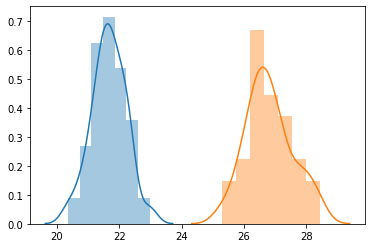

In [63]:
sns.distplot(sample_quant_zero), sns.distplot(sample_quant_dis)

In [69]:
hist_data = [sample_quant_zero, sample_quant_dis]
group_labels = ['Zero','Discounts']
fig = ff.create_distplot(hist_data, group_labels, bin_size = 0.25)
fig.show()

In [71]:
t, p = scs.ttest_ind(sample_quant_zero, sample_quant_dis, equal_var=False)
p

4.1469659260565076e-35

In [73]:
scs.f_oneway(sample_quant_zero, sample_quant_dis)

F_onewayResult(statistic=907.2118373923914, pvalue=4.137184182277263e-37)

In [77]:
effect_size = cohens_d(sample_quant_zero, sample_quant_dis)
effect_size

-7.776939575404504

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

In [80]:
power = tt_ind_solve_power(effect_size=effect_size,
                           nobs1=len(sample_quant_zero),
                           alpha=0.05)
power

1.0

## Conclusion

We have 95% confidence that products sold with a discount will have a higher mean quantities sold than products sold without a discount.

# Question 2: Is there a difference in number of orders and territory? 

In [271]:
cur.execute("""SELECT * FROM 'order' o join orderdetail od on o.id = od.orderid join employee e on o.employeeid = e.id join employeeterritory et on e.id = et.employeeid join territory t on et.territoryid = t.id;
          """)
terr_df = pd.DataFrame(cur.fetchall())
terr_df.columns = [x[0] for x in cur.description]
terr_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,...,Photo,Notes,ReportsTo,PhotoPath,Id,EmployeeId,TerritoryId,Id,TerritoryDescription,RegionId
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp,5/02903,5,02903,02903,Providence,1
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp,5/07960,5,07960,07960,Morristown,1
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp,5/08837,5,08837,08837,Edison,1
3,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp,5/10019,5,10019,10019,New York,1
4,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,...,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp,5/10038,5,10038,10038,New York,1


In [272]:
terr_df.shape

(10129, 44)

In [273]:
terr_df.isna().sum()

Id                          0
CustomerId                  0
EmployeeId                  0
OrderDate                   0
RequiredDate                0
ShippedDate               289
ShipVia                     0
Freight                     0
ShipName                    0
ShipAddress                 0
ShipCity                    0
ShipRegion                  0
ShipPostalCode            308
ShipCountry                 0
Id                          0
OrderId                     0
ProductId                   0
UnitPrice                   0
Quantity                    0
Discount                    0
Id                          0
LastName                    0
FirstName                   0
Title                       0
TitleOfCourtesy             0
BirthDate                   0
HireDate                    0
Address                     0
City                        0
Region                      0
PostalCode                  0
Country                     0
HomePhone                   0
Extension 

In [274]:
terr_df['order_price'] = (terr_df['UnitPrice']/1+terr_df['Discount']) * terr_df['Quantity']


In [275]:
territories = terr_df.TerritoryDescription.unique()
type(list(territories))
territories

array(['Providence', 'Morristown', 'Edison', 'New York', 'Mellvile',
       'Fairport', 'Phoenix', 'Scottsdale', 'Bellevue', 'Redmond',
       'Seattle', 'Rockville', 'Greensboro', 'Cary', 'Atlanta',
       'Savannah', 'Orlando', 'Tampa', 'Hollis', 'Portsmouth',
       'Southfield', 'Troy', 'Bloomfield Hills', 'Roseville',
       'Minneapolis', 'Wilton', 'Neward', 'Philadelphia', 'Beachwood',
       'Findlay', 'Racine', 'Westboro', 'Bedford', 'Georgetow', 'Boston',
       'Cambridge', 'Braintree', 'Louisville', 'Hoffman Estates',
       'Chicago', 'Denver', 'Colorado Springs', 'Santa Monica',
       'Menlo Park', 'San Francisco', 'Campbell', 'Santa Clara',
       'Santa Cruz'], dtype=object)

In [276]:
tdict = {}
for i, t in enumerate(territories):
    tdict[t] = terr_df.loc[terr_df['TerritoryDescription']==t, 'order_price']
    print(tdict)

t64, 'Redmond': 24       167.40
29      1696.00
212      532.00
217      196.25
275       48.00
         ...   
9522      94.50
9527     665.00
9532     344.00
9685      37.50
9690    1272.00
Name: order_price, Length: 168, dtype: float64, 'Seattle': 25       167.40
30      1696.00
213      532.00
218      196.25
276       48.00
         ...   
9523      94.50
9528     665.00
9533     344.00
9686      37.50
9691    1272.00
Name: order_price, Length: 168, dtype: float64, 'Rockville': 31         77.00
34       1489.25
37        254.25
52       2594.00
55         51.25
          ...   
10028     357.50
10031    4322.50
10070     505.00
10073     470.00
10076      94.50
Name: order_price, Length: 420, dtype: float64, 'Greensboro': 32         77.00
35       1489.25
38        254.25
53       2594.00
56         51.25
          ...   
10029     357.50
10032    4322.50
10071     505.00
10074     470.00
10077      94.50
Name: order_price, Length: 420, dtype: float64, 'Cary': 33         77.00
36 

In [277]:
tdict.keys()

dict_keys(['Providence', 'Morristown', 'Edison', 'New York', 'Mellvile', 'Fairport', 'Phoenix', 'Scottsdale', 'Bellevue', 'Redmond', 'Seattle', 'Rockville', 'Greensboro', 'Cary', 'Atlanta', 'Savannah', 'Orlando', 'Tampa', 'Hollis', 'Portsmouth', 'Southfield', 'Troy', 'Bloomfield Hills', 'Roseville', 'Minneapolis', 'Wilton', 'Neward', 'Philadelphia', 'Beachwood', 'Findlay', 'Racine', 'Westboro', 'Bedford', 'Georgetow', 'Boston', 'Cambridge', 'Braintree', 'Louisville', 'Hoffman Estates', 'Chicago', 'Denver', 'Colorado Springs', 'Santa Monica', 'Menlo Park', 'San Francisco', 'Campbell', 'Santa Clara', 'Santa Cruz'])

In [278]:
tdict['Providence'].count()

117

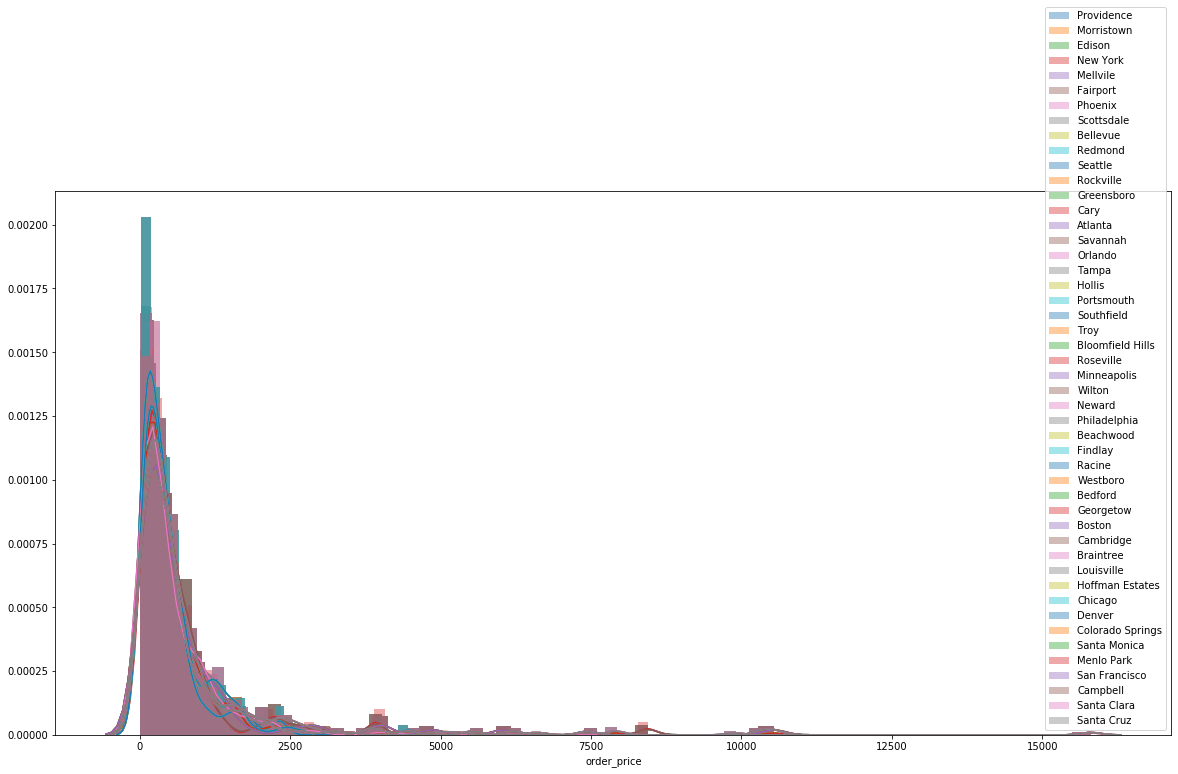

In [286]:
plt.figure(figsize=(20,10))
for t in tdict.keys():
    sns.distplot(tdict[t], label=t)
plt.legend();


In [280]:
for t in tdict.keys():
    test_for_normality(tdict[t])

reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null
reject the null


In [281]:
samps = {}
for t in tdict.keys():
    samps[t] = generate_sample_mus(tdict[t])

In [282]:
for samp in samps:
    test_for_normality(samps[samp])

fail to reject the null
fail to reject the null
reject the null
reject the null
fail to reject the null
reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null
fail to reject the null


In [283]:
multicompare_terr = MultiComparison(terr_df.order_price, terr_df.TerritoryDescription)

In [284]:
tukey_hsd = multicompare_terr.tukeyhsd(alpha=.05)
simple_table = tukey_hsd.summary()
simple_table

group1,group2,meandiff,p-adj,lower,upper,reject
Atlanta,Beachwood,-151.1638,0.9,-522.9182,220.5907,False
Atlanta,Bedford,74.0827,0.9,-305.6819,453.8472,False
Atlanta,Bellevue,-198.3607,0.9,-622.6427,225.9212,False
Atlanta,Bloomfield Hills,112.4526,0.9,-384.9233,609.8286,False
Atlanta,Boston,74.0827,0.9,-305.6819,453.8472,False
Atlanta,Braintree,74.0827,0.9,-305.6819,453.8472,False
Atlanta,Cambridge,74.0827,0.9,-305.6819,453.8472,False
Atlanta,Campbell,140.1523,0.9,-277.7518,558.0564,False
Atlanta,Cary,-67.637,0.9,-397.9603,262.6863,False
Atlanta,Chicago,140.1523,0.9,-277.7518,558.0564,False


## Tukey Test
H0: There is no difference between average order prices in each territory.

HA: Different territories generate significantly different sales revenue per order.

## Conclusion

We fail to reject the null hypothesis and conclude that there is no significant difference between average order prices in each territory.

# Question 3: {You decide}

In [18]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [19]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)